Epoch 10/50 loss=0.1037 acc=0.9758
Epoch 20/50 loss=0.0544 acc=0.9824
Epoch 30/50 loss=0.0374 acc=0.9890
Epoch 40/50 loss=0.0255 acc=0.9934
Epoch 50/50 loss=0.0174 acc=0.9956

Test accuracy: 0.9737

Матриця змішування:
[[72  0]
 [ 3 39]]

Classification report:
               precision    recall  f1-score   support

   Benign (0)       0.96      1.00      0.98        72
Malignant (1)       1.00      0.93      0.96        42

     accuracy                           0.97       114
    macro avg       0.98      0.96      0.97       114
 weighted avg       0.97      0.97      0.97       114



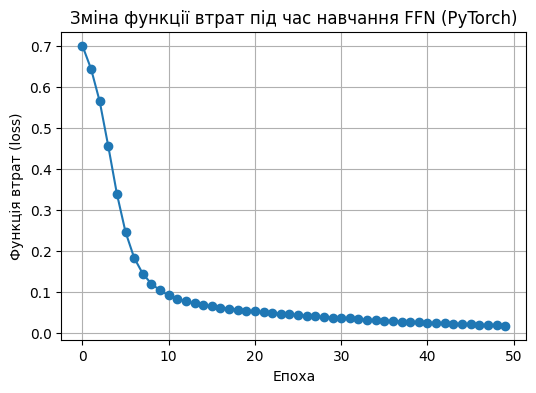

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

# 1) Завантаження та підготовка даних
data = pd.read_csv("breast-cancer.csv")

# Прибираємо неінформативний стовпець
data = data.drop(columns=["id"])

# Ціль: M -> 1 (malignant), B -> 0 (benign)
data["diagnosis"] = data["diagnosis"].map({"M": 1, "B": 0})

X = data.drop(columns=["diagnosis"]).values
y = data["diagnosis"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#  Масштабування ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) Перетворюємо в тензори
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train,        dtype=torch.float32).view(-1, 1)

X_test_t  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,         dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

# 3) Модель повнозв’язаної нейромережі
class FFN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 30),
            nn.ReLU(),
            nn.Linear(30, 15),
            nn.ReLU(),
            nn.Linear(15, 1),
            nn.Sigmoid()  # вихід — ймовірність класу 1
        )

    def forward(self, x):
        return self.net(x)

model = FFN(input_dim=X_train_t.shape[1])

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 4) Цикл навчання з записом loss_history
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        preds = model(xb)             # forward
        loss = criterion(preds, yb)   # обчислюємо loss
        loss.backward()               # backprop
        optimizer.step()              # оновлюємо ваги

        epoch_loss += loss.item() * xb.size(0)

        preds_label = (preds >= 0.5).float()
        correct += (preds_label == yb).sum().item()
        total += xb.size(0)

    train_loss = epoch_loss / total
    train_acc = correct / total
    loss_history.append(train_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} "
              f"loss={train_loss:.4f} acc={train_acc:.4f}")

# 5) Оцінка на тестових даних
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        preds = model(xb)
        preds_label = (preds >= 0.5).float()

        y_true.extend(yb.numpy().ravel().tolist())
        y_pred.extend(preds_label.numpy().ravel().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

test_acc = accuracy_score(y_true, y_pred)
print(f"\nTest accuracy: {test_acc:.4f}")

print("\nМатриця змішування:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification report:")
print(classification_report(
    y_true, y_pred,
    target_names=["Benign (0)", "Malignant (1)"]
))

# 6) Графік кривої втрат
plt.figure(figsize=(6,4))
plt.plot(loss_history, marker="o")
plt.xlabel("Епоха")
plt.ylabel("Функція втрат (loss)")
plt.title("Зміна функції втрат під час навчання FFN (PyTorch)")
plt.grid(True)
plt.show()